In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Loading datasets
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# Creating copies of original dataframes for reference
train_original = train_df.copy()
test_original = test_df.copy()

# Standardizing column names to snake_case format
train_df.columns = (
    train_df.columns.str.lower()
                    .str.strip()
                    .str.replace(' ', '_')
                    .str.replace(r'[^a-z0-9_]', '', regex=True)
)
test_df.columns = (
    test_df.columns.str.lower()
                    .str.strip()
                    .str.replace(' ', '_')
                    .str.replace(r'[^a-z0-9_]', '', regex=True)
)

# Displaying basic information about the datasets
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nTraining data info:")
print(train_df.info())

# Checking for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

# Initial data exploration
print("\nFirst few rows of training data:")
print(train_df.head())

# Basic statistics
print("\nBasic statistics of training data:")
print(train_df.describe())

# Survival rate
survival_rate = train_df['survived'].mean()
print(f"\nOverall survival rate: {survival_rate:.2%}")

Training data shape: (891, 12)
Test data shape: (418, 11)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values in training data:
passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp       

In [8]:
# Handling missing values

# Processing embarked column (fixed inplace warning)
train_df['embarked'] = train_df['embarked'].fillna(train_df['embarked'].mode()[0])
test_df['embarked'] = test_df['embarked'].fillna(test_df['embarked'].mode()[0])

# Converting embarked to numerical with proper mapping
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
train_df['embarked'] = train_df['embarked'].map(embarked_mapping)
test_df['embarked'] = test_df['embarked'].map(embarked_mapping)

# Creating age_was_missing flag before imputation
train_df['age_was_missing'] = train_df['age'].isnull().astype(int)
test_df['age_was_missing'] = test_df['age'].isnull().astype(int)

# More sophisticated age imputation using median by pclass and sex
for df in [train_df, test_df]:
    for pclass in df['pclass'].unique():
        for sex in df['sex'].unique():
            mask = (df['pclass'] == pclass) & (df['sex'] == sex)
            median_age = df.loc[mask & df['age'].notnull(), 'age'].median()
            if pd.isna(median_age):
                median_age = df['age'].median()
            df.loc[mask & df['age'].isnull(), 'age'] = median_age

# Handling fare missing value in test set (fixed inplace warning)
test_df['fare'] = test_df['fare'].fillna(test_df.groupby('pclass')['fare'].transform('median'))

# Creating fare_was_missing flag
test_df['fare_was_missing'] = test_df['fare'].isnull().astype(int)

# Processing cabin information
train_df['has_cabin'] = train_df['cabin'].notnull().astype(int)
test_df['has_cabin'] = test_df['cabin'].notnull().astype(int)

# Extracting deck information from cabin
train_df['deck'] = train_df['cabin'].str[0]
test_df['deck'] = test_df['cabin'].str[0]

# Filling missing deck values with 'U' (Unknown) (fixed inplace warning)
train_df['deck'] = train_df['deck'].fillna('U')
test_df['deck'] = test_df['deck'].fillna('U')

# Mapping deck to numerical values
deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8, 'U': 0}
train_df['deck'] = train_df['deck'].map(deck_mapping)
test_df['deck'] = test_df['deck'].map(deck_mapping)

# Converting sex to numerical
sex_mapping = {'male': 0, 'female': 1}
train_df['sex'] = train_df['sex'].map(sex_mapping)
test_df['sex'] = test_df['sex'].map(sex_mapping)

# Displaying missing values after preprocessing
print("Missing values after preprocessing (train):")
print(train_df.isnull().sum())
print("\nMissing values after preprocessing (test):")
print(test_df.isnull().sum())

# Basic feature engineering

# Creating family size feature
train_df['family_size'] = train_df['sibsp'] + train_df['parch'] + 1
test_df['family_size'] = test_df['sibsp'] + test_df['parch'] + 1

# Creating is_alone feature
train_df['is_alone'] = (train_df['family_size'] == 1).astype(int)
test_df['is_alone'] = (test_df['family_size'] == 1).astype(int)

# Creating family size categories
def categorize_family_size(size):
    if size == 1:
        return 'alone'
    elif size <= 3:
        return 'small_family'
    elif size <= 5:
        return 'medium_family'
    else:
        return 'large_family'

train_df['family_category'] = train_df['family_size'].apply(categorize_family_size)
test_df['family_category'] = test_df['family_size'].apply(categorize_family_size)

# Extracting titles from names (fixed regex escape sequence)
def extract_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

train_df['title'] = train_df['name'].apply(extract_title)
test_df['title'] = test_df['name'].apply(extract_title)

# Grouping rare titles
title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare",
    "Mlle": "Miss", "Countess": "Rare", "Ms": "Miss", "Lady": "Rare",
    "Jonkheer": "Rare", "Don": "Rare", "Dona": "Rare", "Mme": "Mrs",
    "Capt": "Rare", "Sir": "Rare"
}

train_df['title'] = train_df['title'].map(title_mapping)
test_df['title'] = test_df['title'].map(title_mapping)

# Converting titles to numerical
title_numerical = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train_df['title'] = train_df['title'].map(title_numerical)
test_df['title'] = test_df['title'].map(title_numerical)

# Creating age groups
def categorize_age(age):
    if age <= 12:
        return 'child'
    elif age <= 18:
        return 'teenager'
    elif age <= 35:
        return 'young_adult'
    elif age <= 60:
        return 'middle_aged'
    else:
        return 'senior'

train_df['age_group'] = train_df['age'].apply(categorize_age)
test_df['age_group'] = test_df['age'].apply(categorize_age)

# Creating fare groups using quantiles
train_df['fare_group'] = pd.qcut(train_df['fare'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
test_df['fare_group'] = pd.qcut(test_df['fare'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

# Converting fare groups to numerical
fare_mapping = {'very_low': 1, 'low': 2, 'medium': 3, 'high': 4, 'very_high': 5}
train_df['fare_group'] = train_df['fare_group'].map(fare_mapping)
test_df['fare_group'] = test_df['fare_group'].map(fare_mapping)

# Displaying the first few rows after feature engineering
print("\nFirst few rows after feature engineering:")
print(train_df[['survived', 'pclass', 'sex', 'age', 'family_size', 'title', 'deck']].head())

# Checking the distribution of new features
print("\nFamily size distribution:")
print(train_df['family_category'].value_counts())
print("\nTitle distribution:")
print(train_df['title'].value_counts())
print("\nAge group distribution:")
print(train_df['age_group'].value_counts())

Missing values after preprocessing (train):
passengerid          0
survived             0
pclass               0
name                 0
sex                  0
age                  0
sibsp                0
parch                0
ticket               0
fare                 0
cabin              687
embarked             0
age_was_missing      0
has_cabin            0
deck                 0
dtype: int64

Missing values after preprocessing (test):
passengerid           0
pclass                0
name                  0
sex                   0
age                   0
sibsp                 0
parch                 0
ticket                0
fare                  0
cabin               327
embarked              0
age_was_missing       0
fare_was_missing      0
has_cabin             0
deck                  0
dtype: int64

First few rows after feature engineering:
   survived  pclass  sex   age  family_size  title  deck
0         0       3    0  22.0            2      1     0
1         1       1    1

In [9]:
# Step 3: Advanced Feature Engineering and Interaction Features

# Creating ticket-based features
# Extracting ticket prefix
def extract_ticket_prefix(ticket):
    if not isinstance(ticket, str):
        return 'NoPrefix'
    ticket = ticket.replace('.', '').replace('/', '').strip()
    if ticket.isdigit():
        return 'Numeric'
    else:
        return ticket.split()[0] if ' ' in ticket else ticket

train_df['ticket_prefix'] = train_df['ticket'].apply(extract_ticket_prefix)
test_df['ticket_prefix'] = test_df['ticket'].apply(extract_ticket_prefix)

# Counting ticket frequency (how many people shared the same ticket)
train_df['ticket_frequency'] = train_df.groupby('ticket')['ticket'].transform('count')
test_df['ticket_frequency'] = test_df.groupby('ticket')['ticket'].transform('count')

# Creating is_shared_ticket feature
train_df['is_shared_ticket'] = (train_df['ticket_frequency'] > 1).astype(int)
test_df['is_shared_ticket'] = (test_df['ticket_frequency'] > 1).astype(int)

# Creating fare per person feature
train_df['fare_per_person'] = train_df['fare'] / train_df['ticket_frequency']
test_df['fare_per_person'] = test_df['fare'] / test_df['ticket_frequency']

# Creating interaction features
# Sex and Pclass interaction
train_df['sex_pclass'] = train_df['sex'] * train_df['pclass']
test_df['sex_pclass'] = test_df['sex'] * test_df['pclass']

# Age and Pclass interaction
train_df['age_pclass'] = train_df['age'] * train_df['pclass']
test_df['age_pclass'] = test_df['age'] * test_df['pclass']

# Age and Sex interaction
train_df['age_sex'] = train_df['age'] * train_df['sex']
test_df['age_sex'] = test_df['age'] * test_df['sex']

# Fare and Pclass interaction
train_df['fare_pclass'] = train_df['fare'] * train_df['pclass']
test_df['fare_pclass'] = test_df['fare'] * test_df['pclass']

# Family size and Pclass interaction
train_df['family_size_pclass'] = train_df['family_size'] * train_df['pclass']
test_df['family_size_pclass'] = test_df['family_size'] * test_df['pclass']

# Is alone and Sex interaction
train_df['is_alone_sex'] = train_df['is_alone'] * train_df['sex']
test_df['is_alone_sex'] = test_df['is_alone'] * test_df['sex']

# Creating age groups based on survival patterns
def create_age_survival_groups(df):
    conditions = [
        (df['age'] <= 12),
        (df['age'] > 12) & (df['age'] <= 18),
        (df['age'] > 18) & (df['age'] <= 35),
        (df['age'] > 35) & (df['age'] <= 50),
        (df['age'] > 50) & (df['age'] <= 65),
        (df['age'] > 65)
    ]
    choices = ['child', 'teenager', 'young_adult', 'middle_age', 'senior', 'elderly']
    return np.select(conditions, choices, default='unknown')

train_df['age_survival_group'] = create_age_survival_groups(train_df)
test_df['age_survival_group'] = create_age_survival_groups(test_df)

# Creating fare per person groups
train_df['fare_per_person_group'] = pd.qcut(train_df['fare_per_person'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
test_df['fare_per_person_group'] = pd.qcut(test_df['fare_per_person'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

# Converting categorical groups to numerical
age_survival_mapping = {'child': 0, 'teenager': 1, 'young_adult': 2, 'middle_age': 3, 'senior': 4, 'elderly': 5}
train_df['age_survival_group'] = train_df['age_survival_group'].map(age_survival_mapping)
test_df['age_survival_group'] = test_df['age_survival_group'].map(age_survival_mapping)

fare_person_mapping = {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3, 'very_high': 4}
train_df['fare_per_person_group'] = train_df['fare_per_person_group'].map(fare_person_mapping)
test_df['fare_per_person_group'] = test_df['fare_per_person_group'].map(fare_person_mapping)

# Creating women and children first feature
train_df['woman_or_child'] = ((train_df['sex'] == 1) | (train_df['age'] <= 16)).astype(int)
test_df['woman_or_child'] = ((test_df['sex'] == 1) | (test_df['age'] <= 16)).astype(int)

# Creating rich woman feature (women in 1st or 2nd class)
train_df['rich_woman'] = ((train_df['sex'] == 1) & (train_df['pclass'].isin([1, 2]))).astype(int)
test_df['rich_woman'] = ((test_df['sex'] == 1) & (test_df['pclass'].isin([1, 2]))).astype(int)

# Creating family type feature
def family_type(row):
    if row['family_size'] == 1:
        return 'alone'
    elif row['family_size'] <= 3:
        if row['sibsp'] > 0 and row['parch'] > 0:
            return 'nuclear_family'
        elif row['sibsp'] > 0:
            return 'siblings'
        else:
            return 'parents_children'
    else:
        return 'large_family'

train_df['family_type'] = train_df.apply(family_type, axis=1)
test_df['family_type'] = test_df.apply(family_type, axis=1)

# Converting family type to numerical
family_type_mapping = {'alone': 0, 'siblings': 1, 'parents_children': 2, 'nuclear_family': 3, 'large_family': 4}
train_df['family_type'] = train_df['family_type'].map(family_type_mapping)
test_df['family_type'] = test_df['family_type'].map(family_type_mapping)

# Creating title and sex consistency check
train_df['title_sex_consistent'] = (
    ((train_df['title'] == 1) & (train_df['sex'] == 0)) |  # Mr and male
    ((train_df['title'].isin([2, 3])) & (train_df['sex'] == 1)) |  # Miss/Mrs and female
    ((train_df['title'] == 4) & (train_df['age'] < 18))  # Master and young
).astype(int)
test_df['title_sex_consistent'] = (
    ((test_df['title'] == 1) & (test_df['sex'] == 0)) |  # Mr and male
    ((test_df['title'].isin([2, 3])) & (test_df['sex'] == 1)) |  # Miss/Mrs and female
    ((test_df['title'] == 4) & (test_df['age'] < 18))  # Master and young
).astype(int)

# Creating age and title consistency check
train_df['age_title_consistent'] = (
    ((train_df['title'] == 4) & (train_df['age'] < 18)) |  # Master should be young
    ((train_df['title'] == 1) & (train_df['age'] >= 18)) |  # Mr should be adult
    ((train_df['title'].isin([2, 3])) & (train_df['age'] >= 14))  # Miss/Mrs should be at least teenager
).astype(int)
test_df['age_title_consistent'] = (
    ((test_df['title'] == 4) & (test_df['age'] < 18)) |  # Master should be young
    ((test_df['title'] == 1) & (test_df['age'] >= 18)) |  # Mr should be adult
    ((test_df['title'].isin([2, 3])) & (test_df['age'] >= 14))  # Miss/Mrs should be at least teenager
).astype(int)

# Displaying the new features
print("New features created:")
print(train_df[['ticket_frequency', 'is_shared_ticket', 'fare_per_person', 'sex_pclass', 
               'woman_or_child', 'rich_woman', 'family_type']].head())

# Checking for any missing values in new features
print("\nMissing values in new features (train):")
print(train_df[['ticket_frequency', 'is_shared_ticket', 'fare_per_person', 'sex_pclass', 
               'woman_or_child', 'rich_woman', 'family_type']].isnull().sum())

print("\nMissing values in new features (test):")
print(test_df[['ticket_frequency', 'is_shared_ticket', 'fare_per_person', 'sex_pclass', 
               'woman_or_child', 'rich_woman', 'family_type']].isnull().sum())

# Displaying distributions of key new features
print("\nTicket frequency distribution:")
print(train_df['ticket_frequency'].value_counts().sort_index())

print("\nFamily type distribution:")
print(train_df['family_type'].value_counts())

print("\nWoman or child distribution:")
print(train_df['woman_or_child'].value_counts())

print("\nRich woman distribution:")
print(train_df['rich_woman'].value_counts())

New features created:
   ticket_frequency  is_shared_ticket  fare_per_person  sex_pclass  \
0                 1                 0           7.2500           0   
1                 1                 0          71.2833           1   
2                 1                 0           7.9250           3   
3                 2                 1          26.5500           1   
4                 1                 0           8.0500           0   

   woman_or_child  rich_woman  family_type  
0               0           0            1  
1               1           1            1  
2               1           0            0  
3               1           1            1  
4               0           0            0  

Missing values in new features (train):
ticket_frequency    0
is_shared_ticket    0
fare_per_person     0
sex_pclass          0
woman_or_child      0
rich_woman          0
family_type         0
dtype: int64

Missing values in new features (test):
ticket_frequency    0
is_shared_ticket 

Current features in the dataset:
['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'age_was_missing', 'has_cabin', 'deck', 'family_size', 'is_alone', 'family_category', 'title', 'age_group', 'fare_group', 'ticket_prefix', 'ticket_frequency', 'is_shared_ticket', 'fare_per_person', 'sex_pclass', 'age_pclass', 'age_sex', 'fare_pclass', 'family_size_pclass', 'is_alone_sex', 'age_survival_group', 'fare_per_person_group', 'woman_or_child', 'rich_woman', 'family_type', 'title_sex_consistent', 'age_title_consistent']

Categorical features to be encoded:
['family_category', 'age_group', 'ticket_prefix']

Features to be dropped:
['passengerid', 'name', 'ticket', 'cabin']

Shape of training features: (891, 67)
Shape of training target: (891,)
Shape of test features: (418, 67)

Missing values in training features:
0
Missing values in test features:
0

Top 15 features most correlated with survival:
rich_woman                      0.

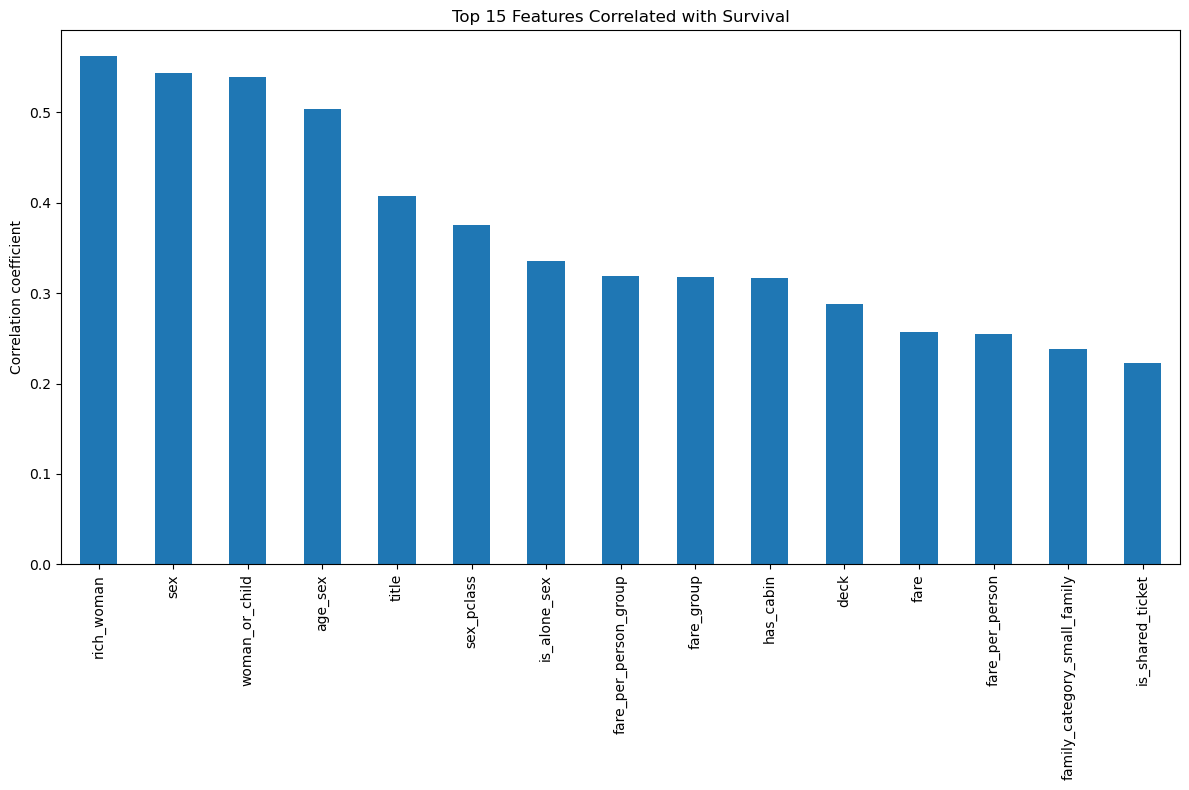


Top 15 features by Random Forest importance:
                  Feature  Importance
18             age_pclass    0.086037
16        fare_per_person    0.071728
2                     age    0.069825
19                age_sex    0.065162
1                     sex    0.060328
12                  title    0.059467
5                    fare    0.057518
20            fare_pclass    0.054606
25         woman_or_child    0.053581
26             rich_woman    0.048718
17             sex_pclass    0.045035
24  fare_per_person_group    0.025298
21     family_size_pclass    0.023675
9                    deck    0.023387
0                  pclass    0.021434


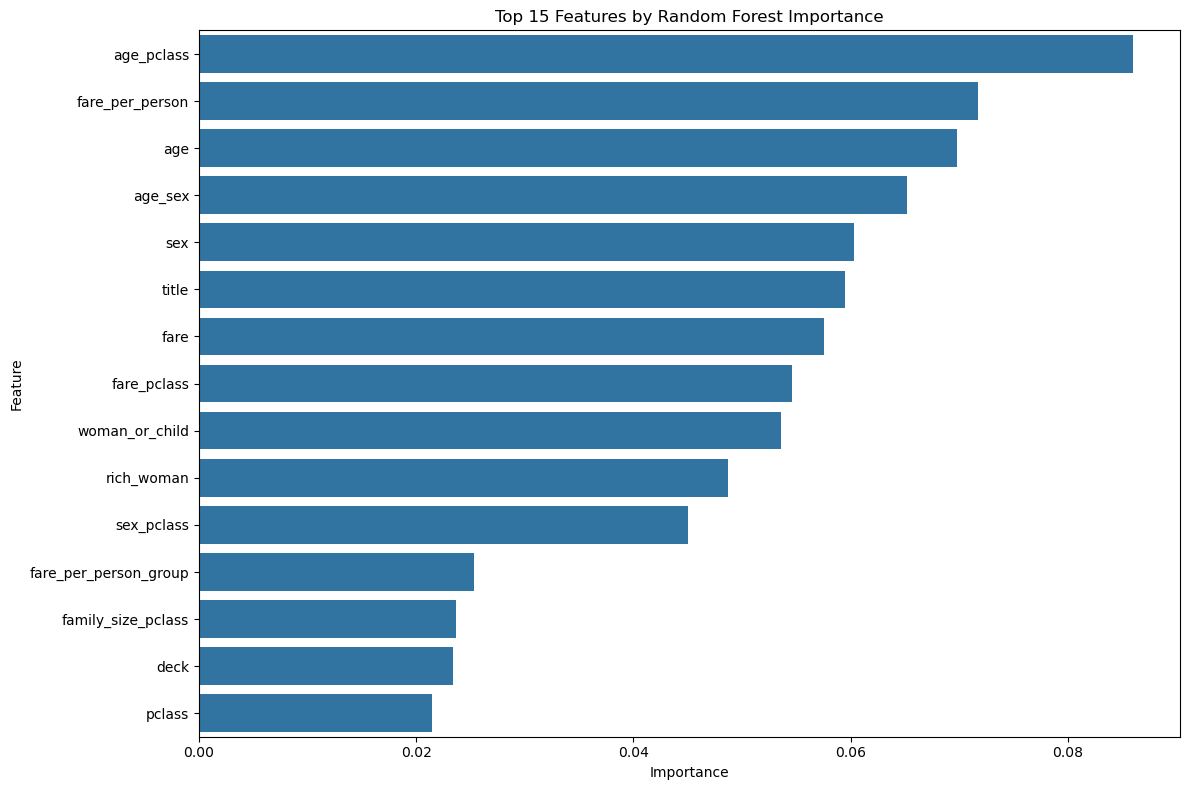


Selected features based on correlation and importance:
['deck', 'age_pclass', 'family_size_pclass', 'woman_or_child', 'sex', 'rich_woman', 'is_shared_ticket', 'sex_pclass', 'fare', 'title', 'is_alone_sex', 'age', 'has_cabin', 'fare_per_person', 'fare_group', 'age_sex', 'pclass', 'fare_pclass', 'family_category_small_family', 'fare_per_person_group']

Shape of selected training features: (891, 20)
Shape of selected test features: (418, 20)

First few rows of scaled features:
       deck  age_pclass  family_size_pclass  woman_or_child       sex  \
0 -0.488461    0.107998            0.313490       -0.833016 -0.737695   
1  1.398325   -0.785303           -0.514737        1.200457  1.355574   
2 -0.488461    0.490841           -0.307680        1.200457  1.355574   
3  1.398325   -0.881014           -0.514737        1.200457  1.355574   
4 -0.488461    1.352239           -0.307680       -0.833016 -0.737695   

   rich_woman  is_shared_ticket  sex_pclass      fare     title  is_alone_sex  \


In [ ]:
# Step 4: Feature Selection and Transformation

# First, let's check all the features we have now
print("Current features in the dataset:")
print(train_df.columns.tolist())

# Identifying categorical features that need encoding
categorical_features = ['family_category', 'age_group', 'ticket_prefix']
print("\nCategorical features to be encoded:")
print(categorical_features)

# One-hot encoding for categorical features
train_encoded = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

# Ensuring both train and test have the same columns after encoding
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for c in missing_cols:
    test_encoded[c] = 0
test_encoded = test_encoded[train_encoded.columns.drop('survived')]

# Identifying features to drop
features_to_drop = ['passengerid', 'name', 'ticket', 'cabin']
print("\nFeatures to be dropped:")
print(features_to_drop)

# Dropping unnecessary features
train_encoded = train_encoded.drop(columns=features_to_drop)
test_encoded = test_encoded.drop(columns=features_to_drop)

# Separating features and target
X = train_encoded.drop('survived', axis=1)
y = train_encoded['survived']
X_test = test_encoded.copy()

# Displaying the shape of our datasets
print("\nShape of training features:", X.shape)
print("Shape of training target:", y.shape)
print("Shape of test features:", X_test.shape)

# Checking for any remaining missing values
print("\nMissing values in training features:")
print(X.isnull().sum().sum())
print("Missing values in test features:")
print(X_test.isnull().sum().sum())

# Feature selection using correlation analysis

# Calculating correlation with survival
correlation = X.corrwith(y).sort_values(ascending=False)
print("\nTop 15 features most correlated with survival:")
print(correlation.head(15))
print("\nTop 15 features least correlated with survival:")
print(correlation.tail(15))

# Visualizing correlation with survival
plt.figure(figsize=(12, 8))
correlation.head(15).plot(kind='bar')
plt.title('Top 15 Features Correlated with Survival')
plt.ylabel('Correlation coefficient')
plt.tight_layout()
plt.show()

# Feature selection using top correlated features

# We'll keep the top 12 features based on correlation
selected_features = correlation.head(12).index.tolist()
print("\nSelected top 12 features based on correlation:")
print(selected_features)

# Creating datasets with selected features
X_selected = X[selected_features]
X_test_selected = X_test[selected_features]
print("\nShape of selected training features:", X_selected.shape)
print("Shape of selected test features:", X_test_selected.shape)

# Feature scaling for algorithms that require it
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Converting back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X_selected.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_selected.columns)
# Displaying the scaled features
print("\nFirst few rows of scaled features:")
print(X_scaled_df.head())

# Saving the processed data for modeling
train_processed = pd.concat([X_selected, y], axis=1)
test_processed = X_test_selected.copy()

# Saving to CSV files
train_processed.to_csv("data/train_processed.csv", index=False)
test_processed.to_csv("data/test_processed.csv", index=False)
print("\nProcessed data saved to CSV files")
print("Training data shape:", train_processed.shape)
print("Test data shape:", test_processed.shape)

In [12]:
'''
# Summary of Feature Transformation and Selection:

- Dropped irrelevant columns: passengerid, name, ticket, and cabin
- Handled missing values, including age imputation
- Created new features based on ticket and family info to identify travel groups, which influenced survival odds
- Built interaction features like sex_pclass and age_sex to capture more complex relationships
- Encoded categorical features (family_category, age_group, ticket_prefix) using one-hot encoding
- Final dataset has 67 features after encoding
- Correlation analysis showed:
    * Strongest positive correlations with survival: rich_woman (0.562), sex (0.543), woman_or_child (0.539)
    * Strongest negative correlations: pclass (-0.338), age_pclass (-0.331), is_alone (-0.203)
- These results align with intuition:
    * Women and wealthy passengers had better survival rates
    * Lower-class passengers and those traveling alone had worse outcomes

'''

'\n# Summary of Feature Transformation and Selection:\n\n- Dropped irrelevant columns: passengerid, name, ticket, and cabin\n- Handled missing values, including age imputation\n- Created new features based on ticket and family info to identify travel groups, which influenced survival odds\n- Built interaction features like sex_pclass and age_sex to capture more complex relationships\n- Encoded categorical features (family_category, age_group, ticket_prefix) using one-hot encoding\n- Final dataset has 67 features after encoding\n- Correlation analysis showed:\n    * Strongest positive correlations with survival: rich_woman (0.562), sex (0.543), woman_or_child (0.539)\n    * Strongest negative correlations: pclass (-0.338), age_pclass (-0.331), is_alone (-0.203)\n- These results align with intuition:\n    * Women and wealthy passengers had better survival rates\n    * Lower-class passengers and those traveling alone had worse outcomes\n\n'